# Preprocessing
### 1. Download the dataset

In [ ]:
import pandas as pd
import kagglehub

path = kagglehub.dataset_download("osmi/mental-health-in-tech-2016")

print("Path to dataset files:", path)

### 2. Retrieve general statistics

In [ ]:
df = pd.read_csv("/home/polina/.cache/kagglehub/datasets/osmi/mental-health-in-tech-2016/versions/2/mental-heath-in-tech-2016_20161114.csv")

pd.set_option('display.max_columns', None)

df.describe()
df.info()

### Remove non-breaking spaces in case they are present

In [ ]:
print(df.columns.tolist())
df.columns = df.columns.str.replace('\xa0', '', regex=False)

### 3. Remove duplicates and repetitive questions

In [ ]:
df = df.drop_duplicates().drop(
    ["If yes, what condition(s) have you been diagnosed with?", 
     "What US state or territory do you live in?", 
     "What US state or territory do you work in?", 
     "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?",
     "Do you know the options for mental health care available under your employer-provided coverage?",
     "Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?",
     "If maybe, what condition(s) do you believe you have?"], 
    axis=1
)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))  # Adjust size to accommodate the number of features
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, cbar_kws={'shrink': 0.8}, vmin=-1, vmax=1)

# Add title and display the plot
plt.title('Correlation Matrix of Features')
plt.show()


### 4. Standardize the diagnoses

In [153]:
import pandas as pd

diagnosis_mapping = {
    "mood disorder": {
        "mood disorder (depression, bipolar disorder, etc)", "depression", "bipolar disorder", 
        "depressive disorder", "mood disorders"
    },
    "anxiety disorder": {
        "anxiety disorder (generalized, social, phobia, etc)", "generalized anxiety disorder", 
        "social anxiety", "phobia", "anxiety", "anxiety disorders"
    },
    "ADHD": {
        "attention deficit hyperactivity disorder", "adhd", "attention deficit disorder"
    },
    "OCD": {
        "obsessive-compulsive disorder", "ocd"
    },
    "PTSD": {
        "post-traumatic stress disorder", "ptsd"
    },
    "stress response": {
        "stress response syndromes", "adjustment disorder", "stress-related disorders"
    },
    "psychotic disorder": {
        "psychotic disorder (schizophrenia, schizoaffective, etc)", "schizophrenia", 
        "schizoaffective disorder"
    },
    "personality disorder": {
        "personality disorder (borderline, antisocial, paranoid, etc)", "borderline personality disorder", 
        "antisocial personality disorder", "paranoid personality disorder"
    },
    "substance use disorder": {
        "substance use disorder", "substance abuse", "alcohol use disorder", 
        "drug addiction", "addictive disorder"
    },
    "dissociative disorder": {
        "dissociative disorder", "dissociative identity disorder"
    },
    "eating disorder": {
        "eating disorder (anorexia, bulimia, etc)", "anorexia", "bulimia"
    }
}

# Reverse the mapping dictionary
reverse_diagnosis_mapping = {}
for standard, synonyms in diagnosis_mapping.items():
    for synonym in synonyms:
        reverse_diagnosis_mapping[synonym.lower()] = standard

# Function to standardize each diagnosis
def map_diagnosis(diagnosis):
    if isinstance(diagnosis, str):
        diagnosis = diagnosis.lower().strip()
        if not diagnosis:
            return "no disease"
        return reverse_diagnosis_mapping.get(diagnosis, "other")
    return "no disease"

# Split the conditions and standardize
df['diagnosed_conditions'] = df['If so, what condition(s) were you diagnosed with?'].str.split('|')
df['diagnosed_conditions'] = df['diagnosed_conditions'].apply(
    lambda conditions: [map_diagnosis(cond) for cond in conditions] if isinstance(conditions, list) else []
)
df['diagnosed_conditions'] = df['diagnosed_conditions'].apply(
    lambda conditions: conditions if conditions else ["no disease"]
)

# One-hot encoding
conditions_dummies = df['diagnosed_conditions'].explode().str.get_dummies().groupby(level=0).sum()

# Concatenate the dummy variables with the original dataframe
df = pd.concat([df.drop(columns=['diagnosed_conditions']), conditions_dummies], axis=1)

df = df.drop("If so, what condition(s) were you diagnosed with?", axis=1)

### Check the value counts for all diagnoses

In [154]:
diagnosis_counts = conditions_dummies.sum(axis=0)
print(diagnosis_counts)

ADHD                      135
OCD                        40
PTSD                       70
anxiety disorder          373
dissociative disorder      10
eating disorder            18
mood disorder             529
no disease                722
other                      21
personality disorder       28
psychotic disorder          8
stress response            31
substance use disorder     41
dtype: int64


### 5. Drop columns with more than 80% missing data

In [155]:
missing_data = df.isnull().mean().round(2)
high_null_cols = missing_data[missing_data > 0.80].index
dropped_columns = high_null_cols.tolist()
df = df.drop(columns=dropped_columns)

print("Dropped columns:", dropped_columns)

Dropped columns: ['Is your primary role within your company related to tech/IT?', 'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?', 'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?']


### 6. Rename specific columns for convenience

In [156]:
df = df.rename(columns={'How many employees does your company or organization have?': 'employees_number',
                        'What is your age?': 'age',
                       'What is your gender?': 'gender',
                       'What country do you live in?': 'country',
                       'What US state or territory do you live in?': 'state',
                       'What country do you work in?': 'country_of_work',
                       'What US state or territory do you work in?': 'state_of_work',
                       'Which of the following best describes your work position?': 'position'})


### 7. Standardize the number of employees and apply one-hot encoding

In [157]:
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

# Accepted employee number ranges
accepted_values = ['26-100', '100-500', '500-1000', 'More than 1000']

df['employees_number'] = np.where(df['employees_number'].isin(accepted_values), 
                                  df['employees_number'], 
                                  np.nan)

employees_dummies = pd.get_dummies(df['employees_number'], prefix='employees')

df_with_encoded = pd.concat([df.drop(columns=['employees_number']), employees_dummies], axis=1)

encoded_columns = [col for col in df_with_encoded.columns if col.startswith('employees_')]

# Apply KNN imputer to fill missing values
imputer = KNNImputer(n_neighbors=3)
encoded_imputed_values = imputer.fit_transform(df_with_encoded[encoded_columns])

encoded_imputed_df = pd.DataFrame(encoded_imputed_values, columns=encoded_columns)
encoded_imputed_df = encoded_imputed_df.astype(int)

df = pd.concat([df.drop(columns=['employees_number']), encoded_imputed_df], axis=1)


### 8. Standardize gender categories

In [158]:
gender_mapping = {
    "male": {"male", "m", "man", "cis male", "male.", "mail", "malr", "cis man", "cisdude", "dude", "male (cis)"},
    "female": {"female", "f", "woman", "cis female", "female/woman", "cis-woman", "fem", "fm", 
               "female (props for making this a freeform field, though)", "female assigned at birth"},
    "non-binary": {"non-binary", "bigender", "genderqueer", "genderfluid", "androgynous", "other", 
                   "genderflux demi-girl", "enby", "afab", "mtf", "genderfluid (born female)", 
                   "female-bodied; no feelings about gender", "genderqueer woman", "nb masculine", 
                   "nonbinary", "agender"}
}

reverse_gender_mapping = {}
for standard, options in gender_mapping.items():
    for option in options:
        reverse_gender_mapping[option] = standard

def map_gender(gender):
    if gender is None:
        return "other"
    gender = str(gender).lower().strip()
    return reverse_gender_mapping.get(gender, "other")

df['gender'] = df['gender'].apply(map_gender)


### 9. Standardize countries

In [159]:
country_region_mapping = {

    'United States of America': 'United States of America',
    'United Kingdom': 'United Kingdom',
    'Canada': 'Canada',
    'Germany': 'Germany',
    'Netherlands': 'Netherlands',
    'Australia': 'Australia',
    'France': 'France',
    'Switzerland': 'Switzerland',
    'India': 'India',
    'Russia': 'Russia',
    'New Zealand': 'New Zealand',
    'Belgium': 'Belgium',
    'South Africa': 'South Africa',
    'Italy': 'Italy',
    'Spain': 'Spain',
    'Other': 'Other',
    'United Arab Emirates': 'Middle East',
    'China': 'China',
    'Japan': 'Japan',
    'Turkey': 'Middle East',

    'Brazil': 'America Other',
    'Argentina': 'America Other',
    'Colombia': 'America Other',
    'Venezuela': 'America Other',
    'Ecuador': 'America Other',
    'Chile': 'America Other',
    'Mexico': 'America Other',
    'Guatemala': 'America Other',
    'Costa Rica': 'America Other',

    'Romania': 'Europe (Eastern)',
    'Poland': 'Europe (Eastern)',
    'Czech Republic': 'Europe (Eastern)',
    'Bosnia and Herzegovina': 'Europe (Eastern)',
    'Estonia': 'Europe (Eastern)',
    'Lithuania': 'Europe (Eastern)',
    'Serbia': 'Europe (Eastern)',
    'Slovakia': 'Europe (Eastern)',

    'Austria': 'Europe (Western)',
    'Belgium': 'Europe (Western)',

    'Norway': 'Europe (Scandinavian)',

    'Greece': 'Europe (Southern)',

    'Algeria': 'Africa',
    'South Africa': 'Africa',

    'Taiwan': 'Asia',
    'Brunei': 'Asia',
    'Vietnam': 'Asia',
    'Bangladesh': 'Asia',

    'Iran': 'Middle East',
    'Iraq': 'Middle East',
    'Syria': 'Middle East'
}

# Apply the mapping to both 'country' and 'country_of_work' columns
df['country'] = df['country'].map(country_region_mapping).fillna('Other')
df['country_of_work'] = df['country_of_work'].map(country_region_mapping).fillna('Other')


### 10. Convert text data into standardized numerical format

In [160]:
mapping = {
    0: {'No', 'Very easy', 'Never', "No, I don't know any", 'No, I only became aware later', 
        'N/A (not currently aware)', 'No, none did', 'None of them', 'None did', "No, because it doesn't matter", "No, because it would impact me negatively", 
        'None of them', "No, it has not", "No, they do not", 'Not open at all', "Never", "No, at none of my previous employers"},
    1: {'Yes', 'Very difficult', 'Yes, I know several', 'Yes, I was aware of all of them', 'Some did', 
        'Yes, always', 'Yes, all of them', 'Yes, they all did', 'Yes, all of them', 'Yes, it has', 
        'Yes, I think they would', 'Yes, they do', 'Very open', 'Yes, I experienced', 'Yes, I observed', 
        'Often', 'Always', 'Yes, at all of my previous employers', "Yes, always"},
    2: {'Somewhat easy', "No, I don't think it would", "No, I don't think they would", 
           "Somewhat not open", "Rarely"},
    3: {'Somewhat difficult', 'I know some', 'Sometimes', 
           "Yes, I think it would", "Yes, I think they would", 'Somewhat open'},
    4: {'I am not sure', 'Neither easy nor difficult', 'Maybe', 'I was aware of some', 
          'Neutral', 'Maybe/Not sure', 'Some of my previous employers', 'Unsure', 'Some of them', "Sometimes, if it comes up"},
    5: {'Not applicable to me', 'Not eligible for coverage / N/A', "I don't know", "Not applicable to me (I do not have a mental illness)"}
}

reverse_feature_mapping = {}
for standard, options in mapping.items():
    for option in options:
        reverse_feature_mapping[option] = standard

def map_response(value):
    return reverse_feature_mapping.get(value, value)

numeric_columns = [
    "Does your employer provide mental health benefits as part of healthcare coverage?",
    "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",
    "Does your employer offer resources to learn more about mental health concerns and options for seeking help?",
    "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?",
    "If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",
    "Do you think that discussing a mental health disorder with your employer would have negative consequences?",
    "Do you think that discussing a physical health issue with your employer would have negative consequences?",
    "Would you feel comfortable discussing a mental health disorder with your coworkers?",
    "Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?",
    "Do you feel that your employer takes mental health as seriously as physical health?",
    "Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?",
    "Do you know local or online resources to seek help for a mental health disorder?",
    "If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",
    "Do you believe your productivity is ever affected by a mental health issue?",
    "Have your previous employers provided mental health benefits?",
    "Were you aware of the options for mental health care provided by your previous employers?",
    "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?",
    "Did your previous employers provide resources to learn more about mental health issues and how to seek help?",
    "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?",
    "Do you think that discussing a mental health disorder with previous employers would have negative consequences?",
    "Do you think that discussing a physical health issue with previous employers would have negative consequences?",
    "Would you have been willing to discuss a mental health issue with your previous co-workers?",
    "Would you have been willing to discuss a mental health issue with your direct supervisor(s)?",
    "Did you feel that your previous employers took mental health as seriously as physical health?",
    "Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?",
    "Would you be willing to bring up a physical health issue with a potential employer in an interview?",
    "Would you bring up a mental health issue with a potential employer in an interview?",
    "Do you feel that being identified as a person with a mental health issue would hurt your career?",
    "Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?",
    "How willing would you be to share with friends and family that you have a mental illness?",
    "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?",
    "Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?",
    "Do you have a family history of mental illness?",
    "Have you had a mental health disorder in the past?",
    "Do you currently have a mental health disorder?",
    "Have you been diagnosed with a mental health condition by a medical professional?",
    "If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?",
    "If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",
    "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?"
]

for col in numeric_columns:
    df[col] = df[col].apply(map_response)

rem_mapping = {  
    'Always': 1,
    'Never': 0,
    'Sometimes': 2,
}

df['Do you work remotely?'] = df['Do you work remotely?'].replace(rem_mapping)

# Convert columns to numeric data types for analysis
df[numeric_columns + ['Do you work remotely?']] = df[numeric_columns + ['Do you work remotely?']].fillna('').apply(pd.to_numeric, errors='coerce')

/tmp/ipykernel_539/185872119.py:77: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Do you work remotely?'] = df['Do you work remotely?'].replace(rem_mapping)


### Check the null values before imputation

In [161]:
pd.set_option('display.max_rows', None)

data_types = df.dtypes
null_counts = df.isnull().sum()

summary = pd.DataFrame({
    'Data Type': data_types,
    'Null Values': null_counts
})

print(summary)

pd.reset_option('display.max_rows')

                                                   Data Type  Null Values
Are you self-employed?                                 int64            0
Is your employer primarily a tech company/organ...   float64          287
Does your employer provide mental health benefi...   float64          287
Has your employer ever formally discussed menta...   float64          287
Does your employer offer resources to learn mor...   float64          287
Is your anonymity protected if you choose to ta...   float64          287
If a mental health issue prompted you to reques...   float64          287
Do you think that discussing a mental health di...   float64          287
Do you think that discussing a physical health ...   float64          287
Would you feel comfortable discussing a mental ...   float64          287
Would you feel comfortable discussing a mental ...   float64          287
Do you feel that your employer takes mental hea...   float64          287
Have you heard of or observed negative

### 11. Missing values imputation:
-  Median imputation in numeric columns with fewer than 250 missing values.
-  kNN imputation in numeric columns with more than 250 missing values.

In [162]:
with pd.option_context('display.max_rows', None):
    print(df.dtypes)

Are you self-employed?                                                                                                                                                                int64
Is your employer primarily a tech company/organization?                                                                                                                             float64
Does your employer provide mental health benefits as part of healthcare coverage?                                                                                                   float64
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?                                              float64
Does your employer offer resources to learn more about mental health concerns and options for seeking help?                                                                         float64
Is your anonymity protected if you choose to take advantage 

In [163]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

# Columns to be handled separately
sep_columns = ["gender", "Why or why not?.1", "Why or why not?"]

df["gender"] = df["gender"].fillna("other")
df[["Why or why not?.1", "Why or why not?"]] = df[["Why or why not?.1", "Why or why not?"]].fillna('')

def map_to_allowed(value, allowed_values):
    return min(allowed_values, key=lambda x: abs(x - value))

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    if column in sep_columns:
        continue
    
    missing_values_count = df[column].isnull().sum()
    
    if missing_values_count <= 250:
        # Impute with median if missing values are less than or equal to 250
        median_value = df[column].median()
        df[column] = df[column].fillna(median_value)
        print(f"Column '{column}' imputed with median value.")
    
    else:
        # Apply KNN imputation for larger datasets, ensure standardized values
        knn_imputer = KNNImputer(n_neighbors=2)
        
        if df[column].notna().any():
            knn_imputed_values = knn_imputer.fit_transform(df[[column]])
            
            allowed_values = df[column].dropna().unique()
            
            df[column] = np.where(df[column].isnull(), 
                                  [map_to_allowed(val, allowed_values) for val in knn_imputed_values.flatten()], 
                                  df[column])
            
            print(f"Column '{column}' imputed using KNN, values replaced with nearest match.")
        else:
            print(f"Column '{column}' contains only NaN values, skipping KNN imputation.")


Column 'Are you self-employed?' imputed with median value.
Column 'Is your employer primarily a tech company/organization?' imputed using KNN, values replaced with nearest match.
Column 'Does your employer provide mental health benefits as part of healthcare coverage?' imputed using KNN, values replaced with nearest match.
Column 'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?' imputed using KNN, values replaced with nearest match.
Column 'Does your employer offer resources to learn more about mental health concerns and options for seeking help?' imputed using KNN, values replaced with nearest match.
Column 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?' imputed using KNN, values replaced with nearest match.
Column 'If a mental health issue prompted you to request a medical leave from work, asking for th

### Check the null counts after imputation

In [164]:
pd.set_option('display.max_rows', None)

data_types = df.dtypes
null_counts = df.isnull().sum()

summary = pd.DataFrame({
    'Data Type': data_types,
    'Null Values': null_counts
})

print(summary)

pd.reset_option('display.max_rows')

                                                   Data Type  Null Values
Are you self-employed?                                 int64            0
Is your employer primarily a tech company/organ...   float64            0
Does your employer provide mental health benefi...   float64            0
Has your employer ever formally discussed menta...   float64            0
Does your employer offer resources to learn mor...   float64            0
Is your anonymity protected if you choose to ta...   float64            0
If a mental health issue prompted you to reques...   float64            0
Do you think that discussing a mental health di...   float64            0
Do you think that discussing a physical health ...   float64            0
Would you feel comfortable discussing a mental ...   float64            0
Would you feel comfortable discussing a mental ...   float64            0
Do you feel that your employer takes mental hea...   float64            0
Have you heard of or observed negative

In [165]:
df['current_position'] = df['position'].apply(lambda x: x.split('|')[-1])

df = df.drop(columns=['position'])
df

,Are you self-employed?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you know local or online resources to seek help for a mental health disorder?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Why or why not?,Would you bring up a mental health issue with a potential employer in an interview?,Why or why not?.1,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?,Do you have a family history of mental illness?,Have you had a mental health disorder in the past?,Do you currently have a mental health disorder?,Have you been diagnosed with a mental health condition by a medical professional?,Have you ever sought treatment for a mental health issue from a mental 

### 12. Visualize the data

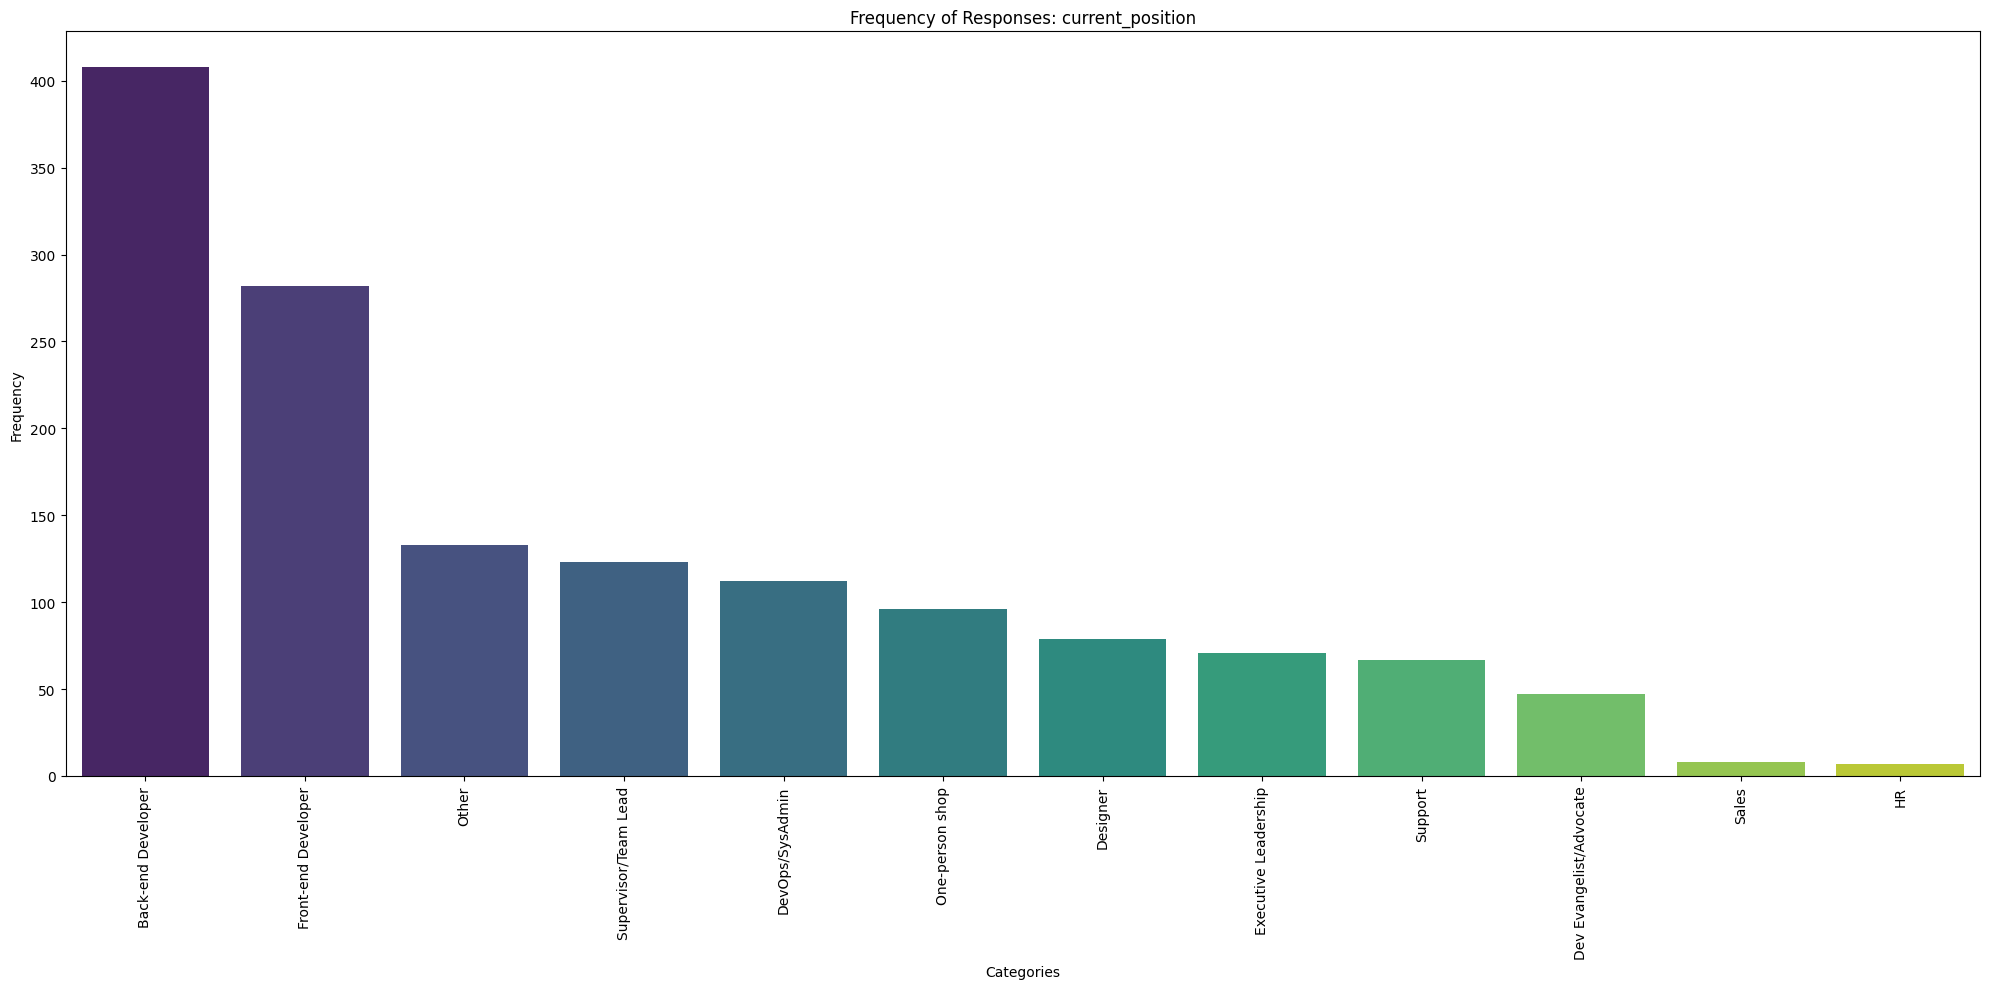

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams["figure.figsize"] = (20, 10)

# Columns to plot
columns = [
   # "If yes, what condition(s) have you been diagnosed with?",
   # "Why or why not?",
   # "Why or why not?.1",
    "current_position"
]

for column in columns:
    value_counts = df[column].value_counts()
    value_counts = value_counts.sort_values(ascending=False)
    
    sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, palette="viridis", legend=False)
    
    plt.xticks(rotation=90)
    
    plt.xlabel('Categories')
    plt.ylabel('Frequency')
    plt.title(f"Frequency of Responses: {column}")
    
    plt.tight_layout()
    plt.show()


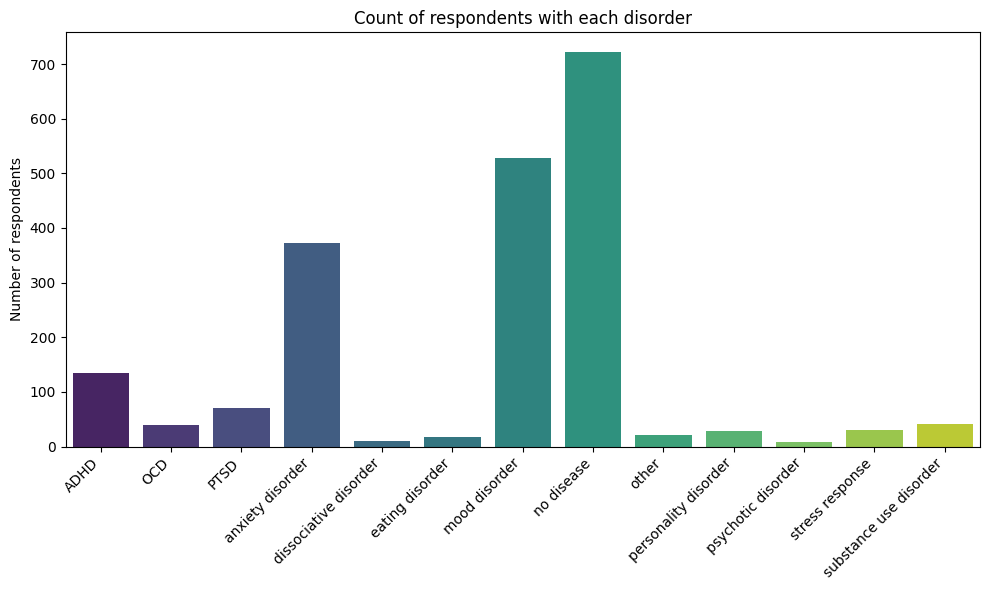

In [173]:
# List of columns to plot
disorder_columns = [
    'ADHD', 'OCD', 'PTSD', 'anxiety disorder', 'dissociative disorder', 
    'eating disorder', 'mood disorder', 'no disease', 'other', 
    'personality disorder', 'psychotic disorder', 'stress response', 
    'substance use disorder'
]

# Plot the data
df_disorders = df[disorder_columns]

disorder_counts = df_disorders.sum(axis=0)

plt.figure(figsize=(10, 6))

sns.barplot(
    x=disorder_counts.index, 
    y=disorder_counts.values,
    hue=disorder_counts.index, 
    palette='viridis',
    legend=False
)

plt.title('Count of respondents with each disorder')
plt.xlabel('')
plt.ylabel('Number of respondents')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### 13. Apply one-hot encoding with get_dummies

In [135]:
# Create dummy variables for categorical columns
gender_dummies = pd.get_dummies(df['gender'], prefix='gender')
country_dummies = pd.get_dummies(df['country'], prefix='country')
work_country_dummies = pd.get_dummies(df['country_of_work'], prefix='work_country')
position_dummies = pd.get_dummies(df['current_position'], prefix='current_position')

# Concatenate dummy variables with the original dataframe
df_with_encoded = pd.concat([df.drop(columns=['gender', 'country', 'country_of_work', 'current_position']),
                              gender_dummies, country_dummies, work_country_dummies, position_dummies], axis=1)

# Identify columns with specific prefix (if this is the intention)
# Note: This part is unclear in your code. Adjusted based on assumption
encoded_columns = [col for col in df_with_encoded.columns if col.startswith('gender_') or
                   col.startswith('country_') or
                   col.startswith('work_country_') or
                   col.startswith('current_position_')]

df_with_encoded[encoded_columns] = df_with_encoded[encoded_columns].astype(int)

df = df_with_encoded
df


,Are you self-employed?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you know local or online resources to seek help for a mental health disorder?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Why or why not?,Would you bring up a mental health issue with a potential employer in an interview?,Why or why not?.1,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?,Do you have a family history of mental illness?,Have you had a mental health disorder in the past?,Do you currently have a mental health disorder?,Have you been diagnosed with a mental health condition by a medical professional?,Have you ever sought treatment for a mental health issue from a mental 

### 14. Preprocess extensive text data:
-  Remove punctuation and standardize
-  Apply tokenization
-  Remove stop words
-  Lemmatize words
-  Apply vectorization with TF-IDF 

In [136]:
import re, string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')


punctuations = '''!()\[\]{};:''\,<>./?@#$%^&*_~'''

if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]

# Remove punctuation from the text columns
df["Why or why not?"] = df["Why or why not?"].astype(str).replace(
    f"[{re.escape(punctuations)}]", "", regex=True
)
df["Why or why not?.1"] = df["Why or why not?.1"].astype(str).replace(
    f"[{re.escape(punctuations)}]", "", regex=True
)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# Define a function to preprocess the text
def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    text = re.sub(r'@\w+', '', text)
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    tokens = word_tokenize(text)
    
    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    text = ' '.join(tokens)
    
    return text


# Preprocess the "Why or why not?.1" column only for conciseness
df["Why or why not?.1"] = df["Why or why not?.1"].apply(lambda x: preprocess_text(str(x)))

# Apply vectorization
vectorizer = TfidfVectorizer(max_features=500)
text_vectors = vectorizer.fit_transform(df["Why or why not?.1"]).toarray()

df = df.drop(columns=["Why or why not?"])
df = df.drop(columns=["Why or why not?.1"])


[nltk_data] Downloading package stopwords to /home/polina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/polina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/polina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/polina/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### 15. Apply scaling and reassemble the data

In [137]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Scale the age column
scaler = StandardScaler()
df['age'] = scaler.fit_transform(df[['age']])

# Check the scaling
print(df['age'].describe()) # Mean should be close to 0, the standard deviation close to 1

# Add text vectors back to the dataframe
text_columns = [f"text_feature_{i}" for i in range(text_vectors.shape[1])]
final_df = pd.concat([df, pd.DataFrame(text_vectors, columns=text_columns)], axis=1)

final_df

count    1.433000e+03
mean    -1.785034e-16
std      1.000349e+00
min     -2.771874e+00
25%     -5.569344e-01
50%     -1.139465e-01
75%      4.176390e-01
max      2.557935e+01
Name: age, dtype: float64


,Are you self-employed?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you know local or online resources to seek help for a mental health disorder?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up a mental health issue with a potential employer in an interview?,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?,Do you have a family history of mental illness?,Have you had a mental health disorder in the past?,Do you currently have a mental health disorder?,Have you been diagnosed with a mental health condition by a medical professional?,Have you ever sought treatment for a mental health issue from a mental health professional?,"If you have 

### Save the preprocessed DataFrame

In [138]:
preprocessed_path = "/home/polina/.cache/kagglehub/datasets/osmi/mental-health-in-tech-2016/versions/2/preprocessed_mental-heath-in-tech-2016_20161114.csv"
final_df.to_csv(preprocessed_path, index=False)